# NLP Data Science Technical Interview
![NLP Data Science](NLP_data_science.jpg)


## Problem
A fictional B2B company sells products to online shops and wants to create a list of potential customers.
They scrapped a large number of major German web sites and labelled some of the data with a flag denoting if the web site is an online shop or not.


### Task 1
Develop a classifier which is able to predict whether a web site is an online shop by looking at the HTML content of its main page.

### Task 2
Using this classifer, create predictions for each of the web sites which are unclassified so far ("dataset 2"). Provide the prediction as a CSV file containing the domain name and a flag that denotes if the respective web site is an online shop.

### Task 3
Explain your approach and its technical details to our team.

### Task 4
Alas, the VP Sales of the company does not trust black box models and thus wants to understand what the model learned and how it comes to its decisions. In order to convince him, illustrate which content a web page needs to contain or how it needs to be structured to be classified as an online shop by your model. The VP Sales is a non-technical person and does not have deep knowledge about data analysis, so keep this part of the presentation as easy to understand as possible.


**NOTE**: We will combine task 3 into task 1, so that as we build the solution, it will also be explained.


## Principles
To solve this problem we will stick to a few basic principles.

* The principle of finding the **lowest hanging fruit**. That is, we will find the the thing that brings the most value with the least effort.
* One the core principles of **Agile**. We will solve the problem **incrementally** and **iteratively**. We don't want to get bogged down in perfecting one aspect and using up all of our time obsessing over one thing.

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd

from utils.data_utils import DataUtils
from utils.HTML_extractor import strip_tags


First things first, let's have a look at our data! How about we start with the classified data csv (`dataset1.csv`) then the unclassified data set (`dataset2.csv`)?

In [2]:
CLASSIFIED_CSV_PATH = 'data/dataset1.csv'

classified_df = DataUtils.load_csv(CLASSIFIED_CSV_PATH)
classified_df


,domain,is_shop
0,111.com,0
1,12xl.de,1
2,1a-buerotechnik.de,1
3,1a-yachtcharter.de,0
4,1blu.de,0
...,...,...
855,zeus-zukunft.de,0
856,zhaw.ch,0
857,zoeliakie-gourmet.at,1
858,zookauf-zwahr.de,1


In [3]:
number_of_entries = len(classified_df)
number_of_shops = len(classified_df[classified_df["is_shop"] == 1])
percent_of_shops = (number_of_shops / number_of_entries)*100
print(
    f'out of {len(classified_df)} entries, {percent_of_shops}% are shops')


out of 860 entries, 50.0% are shops


Oh I just love a balanced data set, but who doesn't? 🙂

In [4]:
UNCLASSIFIED_CSV_PATH = 'data/dataset2.csv'

unclassified_df = DataUtils.load_csv(UNCLASSIFIED_CSV_PATH)
unclassified_df

,domain
0,77records.de
1,absperrtechnik24.de
2,ackermedia.de
3,acris-ecommerce.at
4,adepto-shop.de
...,...
195,xeon-hosting.de
196,xodox.de
197,zaubermode.de
198,zipf-immobilien24.de


Okay dokey, we have two csv files we loaded into pandas that contains the domain names and the flags denoting if the respective web site is an online shop. How about we check out an HTML file?

In [6]:
EXAMPLE_HTML_PATH = 'data/scraped_html/1a-buerotechnik.de.html'

html = DataUtils.load_html(EXAMPLE_HTML_PATH)
html

<!DOCTYPE html>
<html dir="ltr" lang="de"><head>
<!--

		Shopsoftware by Gambio GmbH (c) 2005-2017 [www.gambio.de]

		Gambio GmbH offers you highly scalable E-Commerce-Solutions and Services.
		The Shopsoftware is redistributable under the GNU General Public License (Version 2) [http://www.gnu.org/licenses/gpl-2.0.html].
		based on: E-Commerce Engine Copyright (c) 2006 xt:Commerce, created by Mario Zanier & Guido Winger and licensed under GNU/GPL.
		Information and contribution at http://www.xt-commerce.com

		Please visit our website: www.gambio.de

		-->
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="index,follow,noodp,noydir" name="robots"/>
<meta content="de" name="language"/>
<meta content="K.-R. Kugler" name="author"/>
<meta content="2GrzpAAS3QpIFK9CfFOW6H1zd6mIJXw4EhkiwtvAalQ" name="google-site-verification_"/>
<meta content="(c) 1a-Bürotechnik 2001-2016" name="copyright"/>
<meta content=

Yep, that looks like HTML alright. But it isn't so useful for our purpose of classifying web sites as online shops when taking a strictly NLP approach (It is called Natural *Language* Processing after all, and HTML is not strictly Natural Language). We will need to somehow turn this HTML into something useful for our classifier.

**NOTE**: It is interesting to see in the comments of this specific example it mentions `Shopsoftware by Gambio GmbH`, it might be interesting to see if many of them contain such a blatent reference to being a shop. However, we will stick for right now to the task of stripping down the HTML and classifying it as an online shop via the text of the website itself.

**Did you know?** One of the most time consuming steps in NLP is the cleaning of text data scraped from websites? 😉

In [7]:
extracted_text = strip_tags(html)
extracted_text

" Lastschrift, Kreditkarte und Rechnungskauf ohne Paypal-Konto - 1a-Bürotechnik Ihr Discount-Versand, schnell-kompetent-preiswert JavaScript ist in Ihrem Browser deaktiviert. Aktivieren Sie JavaScript, um alle Funktionen des Shops nutzen und alle Inhalte sehen zu können. Kundenlogin Kundengruppe: Gast Merkzettel Warenkorb Suchen Über uns ►►► Rechnungskauf für Behörden Go Startseite Ihr Warenkorb keine Produkte LOTUS™ In Kürze bei uns verfügbar! Aktenvernichter HSM Securio B24 1,9x15mm Cross-Cut, Stufe P5 01.01.2018 Aktenvernichter HSM Securio B32 0,78x11mm, Stufe P6, autom. Ölung 01.01.2018 Unsere Empfehlungen AVerVision F17-8M Full HD, AVer... 349,98 EUR LED-Deckenleuchte MAULstart, weiß, 120 cm, 35 W 82,80 EUR Aktenvernichter HSM Securio AF500, 1,9x15mm,... 749,98 EUR Mobiles Whiteboard MAULstandard Emaille,... 318,73 EUR Aktenvernichter Fellowes Powershred M-7C... 49,73 EUR Tonrec Toner 31010L ersetzt Lexmark T640,... 64,28 EUR OLYMPIA Registrierkasse Touch 200 weiß,... 859,00 EUR A

Looking at a few other examples (not shown), it looks pretty good for our purpose. Data can always be cleaner, but let's not get stuck cleaning this data further at this time and say it is good enough for now. We will see if we need to do some additional cleaning further down the road. 

Now that we have a way to read and clean up the HTML into normal text strings, we should probably apply that to all of the HTML data and while we are at it, merge it to the classified and unclassified csvs.

To do this we will:
* Get a file list from the HTML files in the directory
* Strip the ".html" extension from the file names
* Match those stripped file names with the domain names in the csvs
* Merge the parsed and stripped HTML to the csvs into a new column called `text`

Getting the file list is pretty straight forward. We will write a function that does this for us and throw it into the the `data_utils.py` file. Here's the output (for the first 10):

In [9]:
SCRAPED_DATA_DIR = 'data/scraped_html/'

file_list = DataUtils.get_file_list(SCRAPED_DATA_DIR)
print(file_list[:10])

['toskanaferien.de.html', 'pc-ostsee.de.html', 'hammerkauf.de.html', 'mobile-laden.com.html', 'lutter.net.html', 'meinemarkenmode.de.html', 'sonnenhotels.de.html', 'gelesi.de.html', 'perfectmallorca.de.html', 'bellanea.de.html']


We will need to write a function that will go through the list of files in the directory and returns a dataframe with the domains and text.

**NOTE**: In the original files, there was a `.ipynb_checkpoints` directory in the `data/scraped_html` directory that we will not be using, so I 🗑️ tossed it out.

In [10]:
text_df = DataUtils.process_html_files(SCRAPED_DATA_DIR)
text_df


,domain,text
0,toskanaferien.de,Home - Toskanaferien HomeUrlaubsort Lari Dolc...
1,pc-ostsee.de,PCO - Privat Charter Ostsee - Yachtcharter Di...
2,hammerkauf.de,Hammerkauf Online-Shop - Baumarkt 02251 650 1...
3,mobile-laden.com,Mobile-Laden.com - Handyzubehör zu Top Preise...
4,lutter.net,Immobilien Makler Rostock Häuser Wohnungen Ka...
...,...,...
1055,nakur.de,Nakur Warenkorb 0 Artikel Ihr Konto Kasse Anm...
1056,babyviduals.de,"Babynahrung tiefgekühlt von Babyviduals, Bio-..."
1057,taschenkaufhaus.de,"Taschen, Rucksäcke und Reisegepäck: Taschenka..."
1058,gastroimmobilien.net,gastroimmobilien.net - Gastro Immobilien Das ...


This dataframe looks pretty good. Next we will merge this dataframe with the training and unclassified dataframes by the `domain` column.

In [11]:
classified_text_df = pd.merge(classified_df, text_df, on="domain")
unclassified_text_df = pd.merge(unclassified_df, text_df, on="domain")

In [12]:
classified_text_df

,domain,is_shop,text
0,111.com,0,dns-net.ch | DNS-NET Services GmbH Our domain...
1,12xl.de,1,Bekleidung in Übergrößen für Herren | Herrenm...
2,1a-buerotechnik.de,1,"Lastschrift, Kreditkarte und Rechnungskauf oh..."
3,1a-yachtcharter.de,0,Yachtcharter - 9196 Yachten online chartern M...
4,1blu.de,0,Neue Internetpräsenz. hosted by www.1blu.de Hi...
...,...,...,...
855,zeus-zukunft.de,0,Zeus Zukunft - Ihr Spezialist für Einkommenss...
856,zhaw.ch,0,Willkommen an der ZHAW | ZHAW Zürcher Hochsch...
857,zoeliakie-gourmet.at,1,Vital Gourmet 03177 25 295 / 0676 60 45 9 45 ...
858,zookauf-zwahr.de,1,Startseite 03581 / 405152 Login Kontakt Waren...


In [ ]:
classified_text_df.to_csv('data/classified_text_df.csv')

In [13]:
unclassified_text_df

,domain,text
0,77records.de,DJ Equipment | DJ Zubehör ★ 77records.de Um 7...
1,absperrtechnik24.de,"Absperrpfosten, Schilder, Fahrradständer und ..."
2,ackermedia.de,Hosting - Avernis Domain bestellen / Domains ...
3,acris-ecommerce.at,E-Commerce & Shopware Agentur aus Linz OÖ ► A...
4,adepto-shop.de,ADEPTO - Reinigungsfachhandel - Versandkosten...
...,...,...
195,xeon-hosting.de,Xeon-Hosting.de TeamSpeak3 Live Chat Warenkor...
196,xodox.de,"XODOX - Webdesign, Server, E-Mail & SEO aus Fo..."
197,zaubermode.de,kunterbunte Kindermode und Babykleidung - gün...
198,zipf-immobilien24.de,Zipf und Partner Immobilien GmbH - Immobilien...


In [ ]:
unclassified_text_df.to_csv('data/unclassified_text_df.csv')

Uh huh, looking pretty good with these dataframes. But I am sure we will get better results if we cleaned the data more. But I'd say we are ready for the next major step...

# Task 1
(with Task 3)

Let's do some machine learning stuff! Well, almost.. There is the matter of figuring out our approach and of course doing the pre-processing that needs to be done.

Sticking with our principles, we will start with the easiest solution and then we will benchmark it and see where it gets us. So instead of doing some crazy SOTA stuff, we will encode the the text into TF-IDF vectors and use that as features for a "classic" intent classifier. 

This is very similar to the task of classifying emails as `spam` or `ham` for another binary classification example, but it can also be considered similar to doing multi-class intent matching that could be used in NLU for tasks found in matching utterances to intents like in a voice assistant. 

### Why are we using TF-IDF?
Well based on experience, we have found that TF-IDF is pretty good at being the features for an intent classifier in tasks like this, yet is super easy to do and computationally inexpensive. It is usually a good place to start.

Our **hypothesis** here is that ranking the terms in the documents by their frequency while lowering the rank of terms that are found in a lot of documents, while disregarding the word order is a good way to get a sense of the overall importance of the terms and therefore makes good features. So this is better than a simple bag of words (BoWs) approach, which would just be getting the frequeny of each term. However, it might not be as good as other approaches that might use deeper context to get more features (such as word embeddings).

Of course we could also use stop words with TF-IDF, but we will stick to just TF-IDF for now and see where that gets us. We just love those low hanging fruits!

### Application
![old school cool](old_school_cool.png)

To do all of this, we will go with the easy to use `sklearn` library. It is what we like to call "old school cool".

It is a great way to get started and explore the relationships of the features, train models, and evaluate them. Luckily, I happen to have written an NLU engine that is open source and uses the same library, so we will use parts of that. Please see this [Secret Sauce AI repo](https://github.com/secretsauceai/NLU-engine-prototype-benchmarks) for more information (watch out: this NLU project is still a major work in progress!). Because the project isn't done yet, there is no pipy package for it yet, so we will just grab the pieces we want and go from there.


Let's load the classified and unclassified dataframes from the previous step.

In [3]:
classified_text_df = DataUtils.load_csv('data/classified_text_df.csv')
unclassified_text_df = DataUtils.load_csv('data/unclassified_text_df.csv')

## Preprocessing TF-IDF

Kicking this step off, we will first create a TF-IDF vectorizer.

In [4]:
from nlu_engine import TfidfEncoder

In [5]:
tfidf_vectors, tfidf_vectorizer = TfidfEncoder.create_vectorizer(
    classified_text_df['text'])

To have a better understanding, let's have a look at the top 100 TF-IDF terms in the training data.

In [6]:
top_100_features = TfidfEncoder.get_top_n_features(
    tfidf_vectorizer, tfidf_vectors, 100)
top_100_features

array(['dc', 'tattoos', '2018', 'auswandern', 'amp', '18', 'hotels',
       'shopper', 'nächte', 'bidok', 'akku', 'leverkusen', 'teppiche',
       'euronics', 'arrangement', 'owatrol', 'kettler', 'weber', 'fl',
       'pickerd', 'name', 'alanya', 'ansehen', 'tee', 'teleclinic',
       'nestlé', 'caparol', 'wandtattoo', 'personen', 'bio', 'teneriffa',
       'thermomix', 'uvstars', 'horizon', 'teneriffa', 'spreewald',
       'bali', 'backyard', '000', 'tui', 'samova', 'emsland', 'hotze',
       'prix', 'doppler', 'stufenmatten', 'laminat', 'lidl', 'hairfor2',
       'gundel', 'shoppen', 'duftholz', 'mli', 'produktgruppen', 'braun',
       'hinzufügen', 'kochwerte', 'conow', 'sae', 'kw', 'sprachreisen',
       'internetpräsenz', 'torsino', 'mille', 'produktgruppen', 'eur',
       'ferienhaus', '2018sa', 'spalte', 'bioratio', 'anleitung',
       'weingarten', 'kundenreservierung', 'heizstrahler', 'pharma',
       'zhaw', 'ledlenser', 'azoren', 'cloud', 'unavailable', 'adessa',
       'gas

NOTE: As this is only a first version we haven't removed stopwords or further cleaning of the text. However, I would experiment more with cleaning the data and benchmarking that in the next version if this were a real project.

## Statistics, machine learning or AI?
Ohhhh yeah, we are ready to go! Well almost... Let's have a quick at a boring math lesson first.  

![statistics, machine learning, AI](https://miro.medium.com/max/1400/1*x7P7gqjo8k2_bj2rTQWAfg.jpeg)

One important thing in the classification of machine learning classifiers is the difference between `descrimintive` and `generative` classifiers. In my opinion, this is one of the most helpful ways to categorize the mathematics behind probabilistic machine learning classifiers.

`Descriminative`: The classifier uses the conditional probability of the features to predict the class directory via the posterior probability of the class, `p(y|x)`. Simply put, it uses the direct inputs, `x` to determine the class.

`Generative`: The classifier uses the joint probability of the inputs, `x` and labels `y` to calculate `p(x,y)` using Bayes rule to pick the most likely label. As the name implies, it is trying to generate the inputs, `x` from the labels, `y`.

Got it? Alright let's go!

### The first classifier example
We will load the modified NLU engine and train a model. We will use `Logistic Regression` for this first example. Why? Because it is a good baseline model that is easy to train and easy to evaluate.

It is very fast to train and run inference on, the performance is pretty outstanding given how light the model is . This is actually why several NLU engines use this for probabilistic inference of intent, such as [Snips NLU](https://github.com/snipsco/snips-nlu).

`Logistic Regression` itself is a discrimitive model. It is a supervised learning model that is used to predict the class of a given sample based on the features of that sample.

Much as the name implies, it uses a logit (logarithmic) function to map linear combinations of features(ie the TFIDF terms here) to probabilities of belonging to a particular class. In our case it is a binary classification problem, meaning that there are only two classes.

In short, we ❤️ `Logistic Regression`!


In [7]:
from nlu_engine import NLUEngine
from nlu_engine import IntentMatcher
from nlu_engine import LR
from nlu_engine import Analytics

In [8]:
LR_model = IntentMatcher.train_classifier(LR, tfidf_vectors, classified_text_df['is_shop'])

Training LogisticRegression(random_state=0, solver='liblinear')


We can breifly check out the prediction of labels here.

In [9]:
IntentMatcher.predict_labels(LR_model, tfidf_vectors)

Predicting labels


array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,

### Analytics

What good is machine learning if we can't benchmark and compare our results? Well, we can!

Let's first demonstrate how to do this with `Logistic Regression` and go step-by-step, then we will put it all together.

In [10]:
predictions = Analytics.cross_validate_classifier(LR, tfidf_vectors, classified_text_df['is_shop'])

Cross validating with LogisticRegression(random_state=0, solver='liblinear')
Time it took to cross validate LogisticRegression(random_state=0, solver='liblinear'): 1.8179833889007568


In [11]:
report = Analytics.generate_report(
    LR, predictions, classified_text_df['is_shop'])
report

Generating report for LogisticRegression(random_state=0, solver='liblinear')


{'0': {'precision': 0.9381898454746137,
  'recall': 0.9883720930232558,
  'f1-score': 0.9626274065685163,
  'support': 430},
 '1': {'precision': 0.9877149877149877,
  'recall': 0.9348837209302325,
  'f1-score': 0.9605734767025089,
  'support': 430},
 'accuracy': 0.9616279069767442,
 'macro avg': {'precision': 0.9629524165948007,
  'recall': 0.9616279069767442,
  'f1-score': 0.9616004416355126,
  'support': 860},
 'weighted avg': {'precision': 0.9629524165948008,
  'recall': 0.9616279069767442,
  'f1-score': 0.9616004416355125,
  'support': 860}}

In [12]:
ENCODING = 'TFIDF'
report_df = Analytics.convert_report_to_df(classifier=LR, report=report, encoding=ENCODING)
report_df

,is_shop,precision,recall,f1-score,support,classifier,encoding
0,0,0.938190,0.988372,0.962627,430.000000,LogisticRegression,TFIDF
1,1,0.987715,0.934884,0.960573,430.000000,LogisticRegression,TFIDF
2,accuracy,0.961628,0.961628,0.961628,0.961628,LogisticRegression,TFIDF
3,macro avg,0.962952,0.961628,0.961600,860.000000,LogisticRegression,TFIDF
4,weighted avg,0.962952,0.961628,0.961600,860.000000,LogisticRegression,TFIDF


We have crammed quite a bit of information into this dataframe, so let's take a look at it and discuss it a bit before we go any further.

The formating of the dataframe isn't perfect, but I personally prefer to keep all the information in one dataframe over having to look at multiple dataframes, and in my opinion it looks nicer than outputting a dictionary like we did above.

We have here our two classes for `is_shop`, that is `0` and `1`. Notice the `accuracy`, `macro avg`, and `weighted avg` are in the same column as `is_shop`. This isn't correct, however as stated, it is just nice to have all of this in one dataframe, so I think we can live with that.

##### What fraction of positive predictions are true predictions?
The `precision` is the proportion of *true positives* over *true positives* and *false positives*.

##### Out of all the true positives, what fraction of them did we identify?
The `recall` is the proportion of *true positives* over *true positives* and *false negatives*.


The `f1-score` is the harmonic mean of precision and recall (2 times the `precision` times the `recall` over the addition of the `precision` and the `recall`). If the `f1-score` is high, it means that the model is doing a good job at predicting the class of a given sample. This is the defacto standard metric for evaluating the performance of a model.

The `support` is the number of samples of the given class that were used to compute the `precision`, `recall`, and `f1-score`. NOTE: the `accuracy` row does not contain the support, but the accuracy across the row.

The `accuracy` is the proportion of samples that were correctly predicted. This is a great measure when you have a binary classification problem and one class isn't more important than another. It isn't so good when you would be dealing with life and death though!

The `macro avg` for the `f1-score` is a metric of the f1 score that calculates independently of the classes, then averages them together.

Whereas `weighted avg` for the `f1-score` is a metric of the f1 score that calculates the f1 score for each class taking into account their `support`, then averages them together. 

Since our classes are balanced, this isn't really interesting, and it can be easily seen that the `macro avg` is the same as the `weighted avg` for our data.


For comparsions we will stick to `macro avg f1-score`.

With this all in mind, we can put it all together to see how well our model performs and get a dataframe of those results.

In [13]:
report_df = NLUEngine.evaluate_intent_classifier(tfidf_vectors=tfidf_vectors, labels=classified_text_df['is_shop'], classifier=LR, encoding=ENCODING)
report_df

Cross validating with LogisticRegression(random_state=0, solver='liblinear')
Time it took to cross validate LogisticRegression(random_state=0, solver='liblinear'): 1.249725103378296
Generating report for LogisticRegression(random_state=0, solver='liblinear')


,is_shop,precision,recall,f1-score,support,classifier,encoding
0,0,0.938190,0.988372,0.962627,430.000000,LogisticRegression,TFIDF
1,1,0.987715,0.934884,0.960573,430.000000,LogisticRegression,TFIDF
2,accuracy,0.961628,0.961628,0.961628,0.961628,LogisticRegression,TFIDF
3,macro avg,0.962952,0.961628,0.961600,860.000000,LogisticRegression,TFIDF
4,weighted avg,0.962952,0.961628,0.961600,860.000000,LogisticRegression,TFIDF


### Benchmark them all
Now we can simply run this over a bunch of different classifiers and see which one performs best.

For this I have selected the following classifiers:
* `Gaussian Naive Bayes` is a generative classifier, I would guess that it won't perform as well as `Logistic Regression` for example, and perhaps will perform the worst. It can be good when you have really sparse data though!
* `Logistic Regression` which has already been discussed.
* `Decision Tree` is descriminative.
* `Random Forest` is another personal favorite of mine. It is a descriminative classifier. As the name implies, it randomly bags up features to form descrion trees via permutation. It is known as an ensemble classifier because it takes the permutated trees and ensembles them together into a forest.
* `K-Nearest Neighbors` is a descriminative classifier. As the name tells us, it uses the nearest neighbors to predict the class of a given sample.
* `AdaBoost` is another tree based discriminative classifier.
* `Support Vector Machine` is a descriminative classifier. It uses hyperplanes to draw boundries between classes based on the support, hench the name. It is a bit more computationally expensive than the other classifiers, but it is a great classifier. I would hypothesize that it could outperform the other classifiers by a small margin.

In [14]:
from nlu_engine import NB, DT, RF, KN, ADA, SVM

classifiers = [LR, DT, RF, KN, ADA, SVM, NB]


In [15]:
classifier_reports_df = NLUEngine.evaluate_all_classifiers(classifiers=classifiers, x_train=tfidf_vectors, y_train=classified_text_df['is_shop'], encoding=ENCODING)

Cross validating with LogisticRegression(random_state=0, solver='liblinear')
Time it took to cross validate LogisticRegression(random_state=0, solver='liblinear'): 1.089665412902832
Generating report for LogisticRegression(random_state=0, solver='liblinear')
Cross validating with DecisionTreeClassifier(random_state=42)
Time it took to cross validate DecisionTreeClassifier(random_state=42): 3.7245254516601562
Generating report for DecisionTreeClassifier(random_state=42)
Cross validating with RandomForestClassifier(random_state=0)
Time it took to cross validate RandomForestClassifier(random_state=0): 8.819599628448486
Generating report for RandomForestClassifier(random_state=0)
Cross validating with KNeighborsClassifier(n_neighbors=100)
Time it took to cross validate KNeighborsClassifier(n_neighbors=100): 0.2633943557739258
Generating report for KNeighborsClassifier(n_neighbors=100)
Cross validating with AdaBoostClassifier(n_estimators=100)
Time it took to cross validate AdaBoostClassifi

In [41]:
classifier_reports_df.to_csv('data/classifier_reports_df.csv')

We can skip running this and go straight to the reports.

In [16]:
classifier_reports_df = DataUtils.load_csv('data/classifier_reports_df.csv')

Let's take a look at the results.

In [17]:
classifier_reports_df[classifier_reports_df['is_shop'] == 'macro avg'].sort_values(by='f1-score', ascending=False)

,is_shop,precision,recall,f1-score,support,classifier,encoding
3,macro avg,0.974788,0.974419,0.974414,860.0,RandomForestClassifier,TFIDF
3,macro avg,0.971239,0.970930,0.970925,860.0,AdaBoostClassifier,TFIDF
3,macro avg,0.962952,0.961628,0.961600,860.0,LogisticRegression,TFIDF
3,macro avg,0.960860,0.959302,0.959268,860.0,SVC,TFIDF
3,macro avg,0.954392,0.952326,0.952271,860.0,KNeighborsClassifier,TFIDF
3,macro avg,0.943083,0.943023,0.943021,860.0,DecisionTreeClassifier,TFIDF
3,macro avg,0.913920,0.911628,0.911505,860.0,GaussianNB,TFIDF


Whoa, `Random Forest` for the win! I was actually a bit suprised, as from my personal experience `Support Vector Machine` is often the best classifier for problems like this. It goes to show, you never can tell. However, it was true that the Gaussian Naive Bayes classifier performed the worst.

It would be interesting to fine tune the parameters of `Random Forest` with a grid search and cross validation to see how well it can possibly perform. However this isn't a Kaggle competition and time is limited, so we won't do that here. I think the score is high enough for this example. 

If time would have allowed, I would have loved to try out using these methods with Word2Vec and I would have especially loved to compare this to more modern classification approaches such as can be found with 🤗 HuggingFace.

# Task 2

And now it's time to use our `Random Forest` classifier to predict the class of the given unlabeled dataset.

## Classification of the unclassified data

In case we skipped ahead, we can load most of the stuff we need for this task here

In [18]:
from nlu_engine import TfidfEncoder
from nlu_engine import NLUEngine
from nlu_engine import IntentMatcher
from nlu_engine import RF

classified_text_df = DataUtils.load_csv('data/classified_text_df.csv')
unclassified_text_df = DataUtils.load_csv('data/unclassified_text_df.csv')

tfidf_vectors, tfidf_vectorizer = TfidfEncoder.create_vectorizer(
    classified_text_df['text'])

Okay dokey, let's train the `Random Forest` classifier.

NOTE: we are using all of the labeled data. Since we have really great cross validated benchmarks, we can skip doing any train/test splits and maximize the value of the data we have to make predictions on the unlabeled dataset.

In [19]:
RF_model = IntentMatcher.train_classifier(RF, tfidf_vectors, classified_text_df['is_shop'])

Training RandomForestClassifier(random_state=0)


In [20]:
unclassified_text_vectors = TfidfEncoder.get_vectors(unclassified_text_df['text'], tfidf_vectorizer)

In [21]:
unclassified_text_predicted_df = unclassified_text_df.copy()

In [22]:
unclassified_text_predicted_df['is_shop_predicted'] = IntentMatcher.predict_labels(
    RF_model, unclassified_text_vectors)


Predicting labels


In [34]:
unclassified_text_predicted_df.to_csv('data/unclassified_text_predicted_df.csv')

## Analysis of the predictions

So how'd we do? Let's find out!

We are going to use a widget called `IPySheet` to display the dataframe nicely and create a boolean column (also just called a button, LOL) for ground truthing our predictions. The column will be called `is_shop`. We will also add a column called `ambiguous`, so if we aren't sure about the prediction, we can mark it as ambiguous.

We will also use `preview_text` instead of `text` for the text column, because the text field can be **HUGE**.

In [23]:
import ipysheet

In [8]:
review_classifications_sheet = DataUtils.create_sheet(
    unclassified_text_predicted_df)
review_classifications_sheet


Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format=None, row_end=199, row_start=0, squeeze_row=Fal…

In [9]:
reviewed_classifications_df = DataUtils.convert_sheet_to_dataframe(review_classifications_sheet)

In [12]:
reviewed_classifications_df.to_csv('data/reviewed_classifications_df.csv')

We can load the annotated dataframe here to skip everything.

In [24]:
reviewed_classifications_df = DataUtils.load_csv('data/reviewed_classifications_df.csv')

After going through and ground truthing our unclassified data, I was unsure of some of the sites.

We will remove these from consideration. I would be curious to know how many of the sites were actually shops.

In [25]:
reviewed_classifications_df[reviewed_classifications_df['ambiguous'] == 1]

,domain,is_shop_predicted,preview_text,is_shop,ambiguous
9,allstars-direktvertrieb.de,1,Allstars-Vertrieb Um Allstars-Vertrieb in vol...,0,1
12,baender24.de,1,Baender24.de Diese Seite benötigt Cookies. Si...,0,1
14,bagel.de,0,Bagel Gruppe OkBagel verwendet Cookies. Mit d...,0,1
31,conmoto.com,0,Conmoto - Home page JavaScript scheint in Ihr...,0,1
32,creative-beads.com,1,| Creative Beads Perlen und Schmuckzubehör Ge...,0,1
37,der-fellmann.de,1,Hochwertige Lammfell & Naturfellprodukte bei ...,0,1
39,deutschesportonline.de,0,Startseite | Deutsche Sport Online GmbH Deuts...,0,1
51,fischers-lagerhaus.de,1,Startseite .fb_hidden{position:absolute;top:-...,0,1
54,fuxtec.de,1,FUXTEC Gartengeräte Sehr gut4.69/5.00Zertifiz...,0,1
71,hundeleben-exklusiv.de,1,Exklusive Hundemode | Hundetaschen Luxus | Hu...,0,1


In [26]:
reviewed_classifications_df = reviewed_classifications_df[
    reviewed_classifications_df['ambiguous'] == 0]


So barring the ambiguous entries, how did we do?

In [27]:
incorrectly_classified_df = reviewed_classifications_df[reviewed_classifications_df['is_shop_predicted'] != reviewed_classifications_df['is_shop']]
incorrectly_classified_df

,domain,is_shop_predicted,preview_text,is_shop,ambiguous
15,baulando.com,1,"BAULANDO - Arbeitsschutz, Baumaschinen, Diama...",0,0
48,estugo.de,1,"Onlineshop Hosting für Gambio, Shopware, JTL ...",0,0
67,hollandrad.de,1,Hollandräder in toller Auswahl! | Hollandrad ...,0,0
88,kreativgewerbe.de,0,"<!--table,div,span,font,p{display:none} -->Pl...",1,0
92,kuechle.de,0,"Küchle - Backen, Dekorieren, Oblaten, Esspapi...",1,0
105,medherbs.de,0,MedHerbs - Bestes aus der Natur Bestes aus der...,1,0
111,modellbau-amstetten.at,0,Startseite Angebot Kontakt Anfahrt Impressum ...,1,0
160,springerle.com,0,www.springerle.com - Herzlich willkommen! Wil...,1,0


In [28]:
number_of_entries = len(reviewed_classifications_df)
percent_correct = round(((number_of_entries - len(
    incorrectly_classified_df)) / number_of_entries), 2)*100

print(
    f'From a total of {len(reviewed_classifications_df)} entries, {percent_correct}% were correctly classified')


From a total of 186 entries, 96.0% were correctly classified


I don't want to dive any deeper into analysis of this data, as I don't feel like my ground truthing might be 100% as there were so many ambiguous sites for me. But I would say this percentage of correct classifications would fall within our expected range.

I am very sure if we would further clean the data (general cleaning, stopwords, etc.) and fine tune the parameters, we could score much higher with this method. It would be interesting to see what would be the results then.

# Task 4

They say that a picture is worth a thousand words. But finding the right picture can be hard. We want to find a way to bring clear transparency to the features used in our classifier for someone who has no knowledge of machine learning. What do we want to explain?

* We want to explain that the classes are binary: a website either has a shop or it doesn't.
* We want to show the features used in the classifier, in this case, the terms.
* Perhaps we should show how important the features are.

When it comes to displaying the ranking of terms, people often use word clouds.

The following cells with code wouldn't be shown to the stakeholders, but they are good to show how we do this. Ideally this visualization would be a part of a powerpoint presentation, not in a notebook. I have also provided an alternative or additional solution which was not implemented.

We need to calculate the features from the classifier and then use them in the diagram. As always, this won't really show 100% of what the classifier is doing, as the classifier is using more than one term to classify the text from the websites, but its a good way to show the features used in the classifier. And it would be important to express that this is just a simplification of the classifier.

In [29]:
feature_importances = RF_model.feature_importances_
feature_importances.shape

(121734,)

In [30]:
feature_names = tfidf_vectorizer.get_feature_names()
len(feature_names)

121734

In [31]:
feature_ranks = zip(feature_names, feature_importances)
feature_ranks_df = pd.DataFrame(feature_ranks)
feature_ranks_df.columns = ['feature', 'rank']

Let's scale the rank so that it works better with a wordcloud.

In [32]:
feature_ranks_df['rank'] = feature_ranks_df['rank'].apply(lambda x: x*10000)

In [33]:
feature_ranks_df.sort_values(by='rank', ascending=False).head(30)

,feature,rank
68467,konto,183.086480
27609,artikel,150.112731
115160,warenkorb,137.972614
121059,zzgl,135.222411
112812,versand,131.022325
65962,kategorien,113.093964
0,00,98.003332
22249,95,88.167877
98274,shops,85.727102
24267,agb,80.277729


Let's take the top 30 features, those should be enough examples for our purpose.

In [34]:
feature_rank_dict = feature_ranks_df.sort_values(by='rank', ascending=False).head(
    30).set_index('feature').to_dict()['rank']

In [35]:
feature_rank_dict


{'konto': 183.08648018614716,
 'artikel': 150.1127310401032,
 'warenkorb': 137.97261423219385,
 'zzgl': 135.22241131174442,
 'versand': 131.0223252527508,
 'kategorien': 113.09396393402804,
 '00': 98.0033321349261,
 '95': 88.16787731175798,
 'shops': 85.72710181006958,
 'agb': 80.27772873742923,
 '90': 65.31059979602215,
 'widerrufsrecht': 63.62539627956463,
 'browser': 62.256957690267285,
 'zubehör': 59.622756345964376,
 'sortiment': 54.1792510598168,
 'versandkosten': 54.09682194700898,
 'datenschutz': 53.90731564297089,
 'anmelden': 53.700981663782855,
 'schwarz': 51.94595899037167,
 'hersteller': 44.689705014401255,
 'produkte': 42.29924216652093,
 'inkl': 41.8052350629152,
 'set': 41.603624523048495,
 'mwst': 39.99568659221729,
 'können': 39.18730456648102,
 'merkzettel': 36.54525023352332,
 'ware': 36.25885351836665,
 'zahlungsarten': 34.41124807081042,
 'javascript': 31.41645481110216,
 'shopzertifikat': 31.361866119184548}

## Stakeholder example
One thing I love is to do presentations. I love combining this technology and explaining it to others, especially very visually! It is very much like teaching a class, and I do enjoy teaching. 

So with that in mind, we could make a cool looking example for the customers to really understand what is going on with all of this AI bla-bla technical stuff.

**Setup**: Of course we would want to explain how well the classifier works, and we will need to explain it either detects a website as a shop or not (binary).

Firstly, I would ask the customer to read the small website text and ask them: **What are the most important keywords that allowed you as a HUMAN to know this is a webshop?** It is better when there are several people in the room to really have them discuss this (make it fun!). After they mention a few, I would point out that some keywords they pick could also indicate that it isn't an online shop, but just a website for a shop that only exists in the real world, and other pitfalls like that (ie word order doesn't matter for this specific solution). 


**NOTE**: I would do this like a game to make it fun!


**NOTE**: I might not use this example text, it was just the first one I picked, perhaps a smaller text or something more clear would be better? This is where I love hearing input from the team(s) or other stakeholders. Also, I would want to have the example text formatted a bit better, look cooler, etc. This is just a prototype of what I would do in an actual presentation...


In [50]:
TEXT = unclassified_text_df['text'][0]

text_encoded = TfidfEncoder.get_vectors_from_string(
    TEXT, tfidf_vectorizer)

TEXT

' DJ Equipment | DJ Zubehör ★ 77records.de Um 77records.de / Dein Shop für DJ-, Studio- und Licht-Equipment in vollem Umfang nutzen zu können, empfehlen wir Ihnen Javascript in Ihrem Browser zu aktiveren. Versandkostenfrei ab 25.- in DE / Tiefpreisgarantie Tel 08241 40 90 10 Fax 08241 40 90 199 77records.de / Dein Shop für DJ-, Studio- und Licht-Equipment Mein Konto Merkzettel Service/Hilfe Deutsch Deutsch Deutsch English Schweiz Warenkorb Warenkorb 0,00 €* Positionen anzeigen Bonuspunkte: 0 Home DIGITAL-DJ DJ Controller Mediaplayer Digital Vinyl Audio Interfaces DJ Software Effektgeräte Cases & Bags Tablet Hüllen, Sleeves & Bags Kabel & Adapter Laptop Ständer DJ-Tische Staubschutzcover Zubehör Digital-DJ Set-Bundles PLATTENSPIELER DJ-Plattenspieler USB Plattenspieler Plattenspieler-Cases Tonabnehmer DJ-Plattenspieler-Sets Phono USB Adapter Phono Vorverstärker Plattenspieler Ersatzteile Plattenspieler Zubehör Schallplatten & CD-Möbel Vinyl DJ-Tische Slipmats Kabel & Adapter Plattenkoff

In [81]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [98]:
words_in_text_ranked = {}
for word in TEXT.split(' '):
    if word in feature_ranks_df['feature'].values:
        words_in_text_ranked[word] = feature_ranks_df[feature_ranks_df['feature']
                                                      == word]['rank'].values[0]

In [99]:
words_in_text_ranked

{'für': 11.366318446951125,
 'und': 7.366595234307822,
 'in': 2.890936112593552,
 'vollem': 12.401130583388857,
 'nutzen': 14.884639553840492,
 'zu': 7.78053022664859,
 'empfehlen': 7.411616914448345,
 'wir': 18.0385043486941,
 'ab': 2.8055140344441183,
 '08241': 0.0,
 '40': 6.289486652399065,
 '90': 65.31059979602215,
 '10': 12.696674095164436,
 '199': 0.0,
 'anzeigen': 0.6380201442047574,
 'right': 0.7401932150807706,
 'steht': 0.5146169915619024,
 'drauf': 0.0,
 'ist': 2.4259722253075804,
 'mit': 7.514410534161497,
 'diesem': 1.1775686777158418,
 'der': 16.246230603267772,
 'gemacht': 1.1411664372729888,
 'verteilt': 0.0,
 'auf': 5.139378428335352,
 'erster': 0.0,
 'leichte': 0.0,
 'leistungsfähige': 0.0,
 'im': 5.527179426237115,
 '2900': 0.0,
 'bietet': 3.767680717118115,
 'dem': 1.9237068729873916,
 'ein': 4.619651500631361,
 'professionelles': 0.0,
 'vier': 2.074628141063596,
 'gut': 9.164668071706505,
 'white': 0.0,
 'solider': 0.0,
 'weiß': 0.360068101830708,
 '50mm': 0.0,
 'e

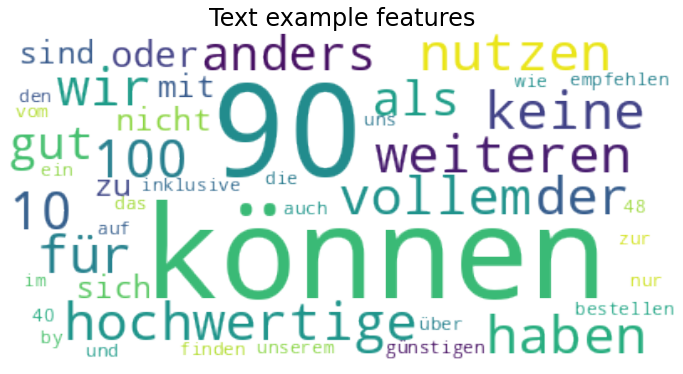

In [101]:
text_example_wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", relative_scaling=0,
                                   normalize_plurals=False, prefer_horizontal=1, min_font_size=10).generate_from_frequencies(words_in_text_ranked)

plt.figure(figsize=(12, 12))
plt.imshow(text_example_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Text example features', fontsize=24)
plt.show()


After our little fun game of guess the important keywords in the text, I would show this word cloud (of course it would have to look waaay cooler for the presentation version!). I might also remove German stopwords (but I might also do this for the classifier too and benchmark these results on the next pass of working on the solution).

I would ask how this aligns with the words guessed by the customers. I assume without stopwords it would probably align pretty well, but we could briefly discuss surprises in there. 

Then I would explain, much like we spotted keywords and tried to figure out what was important, so does our "AI" for all texts.

And then I would show them the general results (rankings) of the classifier, while reminding them these are just the highest ranking features, just like a person the AI uses all of the words in the text to figure out if it is a web shop or not (after all, I didn't give them a chopped up word list out of context, I gave them the actual text, and so it is only fair to do the same for the AI).

In [82]:
RF_feature_wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", relative_scaling=0,
                                 normalize_plurals=False, prefer_horizontal=1, min_font_size=10).generate_from_frequencies(feature_rank_dict)


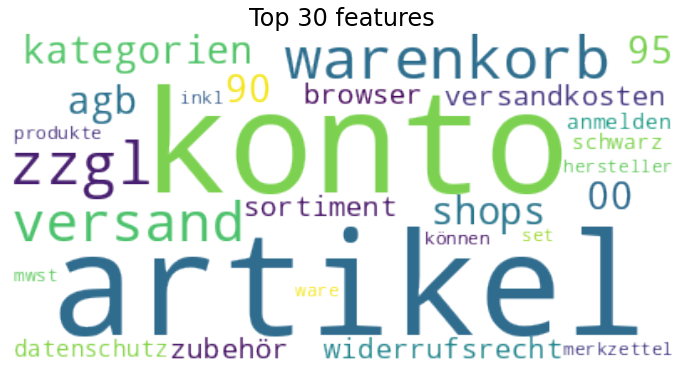

In [83]:
plt.figure(figsize=(12, 12))
plt.imshow(RF_feature_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Top 30 features', fontsize=24)
plt.show()

Generally, the colors need a bit of work on these word clouds, but not bad for a first pass. Yellow is probably the worst color, otherwise they are all pretty good. I would wonder if this company has a specific color palette, I would try to use theirs as much as possible for consistency in the presentation. (I would make sure that they get that these are just the top 30 ranked single features, but the classifier uses the whole text of the website to make the prediction, sometimes facts like this slip through, even if you are sure you explained it!).

Then I would show them a cleaned up version of the output of the classifier (I have hardcoded the domain in here)..

In [112]:
website_prediction = IntentMatcher.predict_labels(
    RF_model, text_encoded)

website_prediction = website_prediction[0]

domain = unclassified_text_df['domain'][0]

if website_prediction == 1:
    print(
        f'The website {domain} is classified as a web shop')

elif website_prediction == 0:
    print(
        f'The website {domain} is classified as a non-web shop')

Predicting labels
The website 77records.de is classified as a web shop


And then it can be seen that it predicts that the website is a shop (for the actual presentation, the output would probably be in German).


NOTES:

* I would love to discuss with the team and/or other stakeholders of the project if another example would be needed for the presentation (ie a non-web shop example).

* One thing that might be too technical for our stake holder would be to use decision tree diagrams, like explained [here](https://towardsdatascience.com/4-ways-to-visualize-individual-decision-trees-in-a-random-forest-7a9beda1d1b7). I would want to discuss with the team and/or other stakeholders if this would be a viable way to dismystify the classifier and how exactly it makes the predictions. 

Of course, this would all be predicated on this being the chosen classifier, perhaps a better solution would present itself. Data science, just like engeerining is an iterative process of improvements through experimentation. I only wish I had more time to have tried out a lot of the solutions we have proposed here (stopwords, word2vec, classifier tuning, etc). But all in all, this was really a fun exercise to do! I hope you have enjoyed it as much as I did.


-Bartmoss